<a href="https://colab.research.google.com/github/saipklvs/LearnDL/blob/main/Visualize_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### These are the steps involved in this tutorial
1. Read the data with appropriate transforms 
2. Set up Tensorboard
3. Write to Tensorboard
4. Inspect a model arcitecture using Tensorboard
5. Use the tensorboard to create Interactive versions
   a. A couple of ways to inspect our training data
   b. How to tract our model's performance as it trains
   c. How to assess our model's performance once it is trained

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

trainset = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=True,
    transform = transform
)

100%|██████████| 26421880/26421880 [00:01<00:00, 18588895.04it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 337939.15it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6062734.93it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19540522.16it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
testset = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    train=False,
    transform=transform
)

In [4]:
## dataloaders
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,
    num_workers=2 
    )

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=4,
    shuffle=False,
    num_workers=2
)

In [5]:
# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [6]:
## Helper function to plot an image
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img = img.mean(dim=0)
  img = img / 2 + 0.5
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [19]:
class Net(nn.Module):
  def __init__(self) -> None:
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*4*4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*4*4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Tensorboard Setup

In [21]:
from torch.utils.tensorboard import SummaryWriter

In [22]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

### Writing an image to tensorboard


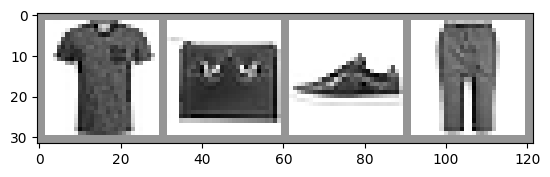

In [26]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

## Create the grid of images
img_grid = torchvision.utils.make_grid(images)

## Show images
matplotlib_imshow(img_grid, one_channel=True)

## Write to tensorboard
writer.add_image("four_fashion_mnist_images", img_grid)

## Inspect the model using TensorBoard

In [27]:
writer.add_graph(net, images)
writer.close()

### Adding a "Projector" to Tensorboard

In [28]:
def select_n_randoms(data, labels, n=100):
    """
    Selects n random datapoints and their corresponding labels from a dataset
    """
    assert len(data) == len(labels)
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

## Select the random images and their target indices
images, labels = select_n_randoms(trainset.data, trainset.targets)

## Get the class labels for each image
class_labels = [classes[lab] for lab in labels]

## Log Embeddings
features = images.view(-1, 28*28)

writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

## Tracking model training with TensorBoard


In [29]:
## Helper function
def images_to_probs(net, images):
  output = net(images)
  _, preds_tensor = torch.max(output, 1)
  preds = np.squeeze(preds_tensor.numpy())
  return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

In [32]:
def plot_classes_preds(net, images, labels):
  print(labels)
  preds, probs = images_to_probs(net, images)
  print(probs)
  print(preds)
  fig = plt.figure(figsize=(12, 48))
  for idx in np.arange(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    matplotlib_imshow(images[idx], one_channel=True)
    ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [33]:
running_loss = 0.0
for epoch in range(1):
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 1000 == 999:
      writer.add_scalar(
          "training_loss", 
          running_loss / 1000, 
          epoch * len(trainloader) + i)
      writer.add_figure(
          'predictions vs. actuals', 
          plot_classes_preds(net, inputs, labels),
          global_step=epoch * len(trainloader) + i
      )
      running_loss = 0.0
print("Finised_Training")

tensor([3, 4, 8, 9])
[0.5558412075042725, 0.5783829092979431, 0.9575377106666565, 0.9368308186531067]
[3 6 8 9]
tensor([8, 5, 4, 7])
[0.48873376846313477, 0.7463531494140625, 0.5311130285263062, 0.991238534450531]
[4 5 4 7]
tensor([5, 3, 2, 6])
[0.9958279728889465, 0.9305310249328613, 0.757926344871521, 0.5381201505661011]
[5 3 2 6]
tensor([7, 3, 8, 1])
[0.9970439076423645, 0.8394990563392639, 0.9975908994674683, 0.9970968961715698]
[7 3 8 1]
tensor([7, 6, 3, 6])
[0.6998523473739624, 0.9616605043411255, 0.4514884352684021, 0.7757743000984192]
[7 6 4 6]
tensor([2, 5, 4, 3])
[0.9473837018013, 0.9810464978218079, 0.9415860772132874, 0.8133135437965393]
[2 5 4 3]
tensor([6, 3, 5, 6])
[0.7530270218849182, 0.5013067126274109, 0.999750554561615, 0.6964061856269836]
[0 4 5 0]
tensor([7, 6, 3, 6])
[0.9211679697036743, 0.48572874069213867, 0.99116450548172, 0.7632116675376892]
[7 2 3 6]
tensor([2, 0, 7, 7])
[0.8252214789390564, 0.8573103547096252, 0.9946534633636475, 0.9993969202041626]
[4 0 7 7

### Assessing trained models with TensorBoard

In [34]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
class_probs = []
class_label = []
with torch.no_grad():
  for data in testloader:
    images, labels = data
    output = net(images)
    class_probs_batch = [F.softmax(el, dim=0) for el in output]
    class_probs.append(class_probs_batch)
    class_label.append(labels)
test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)
